# Music Classification Inference

This notebook demonstrates how to use trained models for music genre prediction on new audio files.

In [11]:
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Load Model

In [12]:
def load_trained_model(model_class, model_path, n_classes, device='cpu'):
    """Load a trained model."""
    model = model_class(n_classes=n_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    print(f"Model loaded from {model_path}")
    return model

## Audio Preprocessing

In [13]:
def preprocess_audio(audio_path, sample_rate=22050, duration=30):
    """Load and preprocess audio file for inference."""
    # Load audio
    waveform, sr = torchaudio.load(audio_path)
    
    # Resample if necessary
    if sr != sample_rate:
        resampler = torchaudio.transforms.Resample(sr, sample_rate)
        waveform = resampler(waveform)
    
    # Convert to mono
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    
    # Pad or truncate to fixed duration
    target_length = sample_rate * duration
    if waveform.shape[1] > target_length:
        waveform = waveform[:, :target_length]
    elif waveform.shape[1] < target_length:
        padding = target_length - waveform.shape[1]
        waveform = torch.nn.functional.pad(waveform, (0, padding))
    
    # Add batch dimension
    waveform = waveform.unsqueeze(0)
    
    return waveform

## Single File Prediction (Genre Classification)

In [14]:
def predict_genre(model, audio_path, genre_names, device='cpu', sample_rate=22050, duration=30):
    """Predict genre for a single audio file."""
    # Preprocess audio
    waveform = preprocess_audio(audio_path, sample_rate, duration)
    waveform = waveform.to(device)
    
    # Make prediction
    with torch.no_grad():
        outputs = model(waveform)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
    
    predicted_genre = genre_names[predicted.item()]
    confidence_score = confidence.item()
    
    # Get top-k predictions
    top_k = min(5, len(genre_names))
    top_probs, top_indices = torch.topk(probabilities[0], top_k)
    
    print(f"\nPrediction for: {Path(audio_path).name}")
    print(f"Predicted Genre: {predicted_genre}")
    print(f"Confidence: {confidence_score*100:.2f}%")
    print(f"\nTop {top_k} predictions:")
    for i, (prob, idx) in enumerate(zip(top_probs, top_indices)):
        print(f"{i+1}. {genre_names[idx.item()]}: {prob.item()*100:.2f}%")
    
    return predicted_genre, confidence_score, probabilities[0].cpu().numpy()

## Multi-label Prediction (Music Tagging)

In [15]:
def predict_tags(model, audio_path, tag_names, device='cpu', sample_rate=22050, 
                 duration=29, threshold=0.5, top_k=10):
    """Predict tags for a single audio file (multi-label)."""
    # Preprocess audio
    waveform = preprocess_audio(audio_path, sample_rate, duration)
    waveform = waveform.to(device)
    
    # Make prediction
    with torch.no_grad():
        outputs = model(waveform)
        probabilities = torch.sigmoid(outputs)
    
    probs = probabilities[0].cpu().numpy()
    
    # Get tags above threshold
    predicted_tags = [(tag_names[i], probs[i]) for i in range(len(tag_names)) 
                      if probs[i] > threshold]
    predicted_tags.sort(key=lambda x: x[1], reverse=True)
    
    # Get top-k tags
    top_tags_indices = np.argsort(probs)[-top_k:][::-1]
    top_tags = [(tag_names[i], probs[i]) for i in top_tags_indices]
    
    print(f"\nPrediction for: {Path(audio_path).name}")
    print(f"\nPredicted tags (threshold={threshold}):")
    if predicted_tags:
        for tag, prob in predicted_tags:
            print(f"  - {tag}: {prob*100:.2f}%")
    else:
        print("  No tags above threshold")
    
    print(f"\nTop {top_k} tags:")
    for i, (tag, prob) in enumerate(top_tags):
        print(f"{i+1}. {tag}: {prob*100:.2f}%")
    
    return predicted_tags, top_tags

## Visualize Predictions

In [16]:
def visualize_prediction(audio_path, probabilities, class_names, sample_rate=22050, save_path=None):
    """Visualize audio and prediction probabilities."""
    # Load audio
    waveform, sr = torchaudio.load(audio_path)
    if sr != sample_rate:
        resampler = torchaudio.transforms.Resample(sr, sample_rate)
        waveform = resampler(waveform)
    
    # Convert to mono
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    
    # Create mel-spectrogram
    mel_transform = torchaudio.transforms.MelSpectrogram(
        sample_rate=sample_rate, n_mels=128
    )
    mel_spec = mel_transform(waveform)
    mel_spec_db = torchaudio.transforms.AmplitudeToDB()(mel_spec)
    
    fig, axes = plt.subplots(3, 1, figsize=(14, 12))
    
    # Plot waveform
    axes[0].plot(waveform[0].numpy())
    axes[0].set_title(f'Waveform - {Path(audio_path).name}')
    axes[0].set_xlabel('Sample')
    axes[0].set_ylabel('Amplitude')
    
    # Plot mel-spectrogram
    im = axes[1].imshow(mel_spec_db[0].numpy(), aspect='auto', origin='lower')
    axes[1].set_title('Mel-Spectrogram (dB)')
    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Mel Frequency')
    plt.colorbar(im, ax=axes[1])
    
    # Plot prediction probabilities
    axes[2].barh(range(len(class_names)), probabilities)
    axes[2].set_yticks(range(len(class_names)))
    axes[2].set_yticklabels(class_names)
    axes[2].set_xlabel('Probability')
    axes[2].set_title('Genre Predictions')
    axes[2].set_xlim([0, 1])
    axes[2].grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        plt.close()
        plt.show()
    else:
        plt.show()

In [17]:
def visualize_batch_predictions(model, data_loader, class_names, device='cpu', num_samples=9, save_path=None):
    """Visualize predictions for samples from different classes."""
    model.eval()
    
    # Collect samples from different classes
    collected_inputs = []
    collected_labels = []
    found_classes = set()
    
    # Iterate through loader to find diverse samples
    # Limit to checking a few batches to avoid taking too long
    max_batches_to_check = 50 
    
    for batch_idx, (inputs, labels) in enumerate(data_loader):
        if batch_idx >= max_batches_to_check:
            break
            
        for i in range(len(labels)):
            label_item = labels[i].item()
            if label_item not in found_classes:
                found_classes.add(label_item)
                collected_inputs.append(inputs[i])
                collected_labels.append(labels[i])
                
                if len(collected_inputs) >= num_samples:
                    break
        
        if len(collected_inputs) >= num_samples:
            break
            
    # If we didn't find enough unique classes, fill up with whatever we have
    if len(collected_inputs) < num_samples:
        if len(collected_inputs) == 0:
             inputs, labels = next(iter(data_loader))
             collected_inputs = [inputs[i] for i in range(min(num_samples, len(inputs)))]
             collected_labels = [labels[i] for i in range(min(num_samples, len(labels)))]

    # Stack them
    inputs = torch.stack(collected_inputs).to(device)
    labels = torch.stack(collected_labels).to(device)
    
    actual_num_samples = len(inputs)
    
    with torch.no_grad():
        outputs = model(inputs)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidences, predicted = torch.max(probabilities, 1)
        
    # Create grid plot
    rows = int(np.ceil(np.sqrt(actual_num_samples)))
    cols = int(np.ceil(actual_num_samples / rows))
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    axes = axes.flatten()
    
    for i in range(actual_num_samples):
        # Compute mel-spectrogram for visualization
        waveform = inputs[i].cpu()
        
        mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=22050, n_mels=128
        )
        mel_spec = mel_transform(waveform)
        mel_spec_db = torchaudio.transforms.AmplitudeToDB()(mel_spec)
        
        ax = axes[i]
        ax.imshow(mel_spec_db[0].numpy(), aspect='auto', origin='lower')
        
        true_label = class_names[labels[i]]
        pred_label = class_names[predicted[i]]
        conf = confidences[i].item()
        
        color = 'green' if true_label == pred_label else 'red'
        ax.set_title(f"True: {true_label}\nPred: {pred_label} ({conf*100:.1f}%)", color=color, fontsize=10)
        ax.axis('off')
        
    # Hide unused subplots
    for i in range(actual_num_samples, len(axes)):
        axes[i].axis('off')
        
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        print(f"Batch predictions saved to {save_path}")
    plt.show()

def plot_confusion_matrix(model, data_loader, class_names, device='cpu', save_path=None):
    """Compute and plot confusion matrix."""
    model.eval()
    all_preds = []
    all_labels = []
    
    print("Computing confusion matrix...")
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            
    cm = confusion_matrix(all_labels, all_preds)
    
    fig, ax = plt.subplots(figsize=(12, 10))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, cmap='Blues', xticks_rotation=45, values_format='d')
    plt.title("Confusion Matrix")
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
        print(f"Confusion matrix saved to {save_path}")
    plt.show()

## Batch Prediction

In [18]:
def predict_directory(model, directory_path, genre_names, device='cpu', 
                      sample_rate=22050, duration=30):
    """Predict genres for all audio files in a directory."""
    directory = Path(directory_path)
    audio_files = list(directory.glob('*.wav')) + list(directory.glob('*.mp3'))
    
    results = []
    
    print(f"\nProcessing {len(audio_files)} files from {directory_path}")
    print("-" * 70)
    
    for audio_file in audio_files:
        try:
            predicted_genre, confidence, _ = predict_genre(
                model, str(audio_file), genre_names, device, sample_rate, duration
            )
            results.append({
                'file': audio_file.name,
                'genre': predicted_genre,
                'confidence': confidence
            })
        except Exception as e:
            print(f"Error processing {audio_file.name}: {e}")
    
    return results

In [19]:
def evaluate_by_song(model, val_dataset, device, changes_file=None, split_name="Test"):
    """
    Evaluate accuracy by aggregating chunk predictions for each song.
    Assumes val_dataset is ordered by song.
    """
    model.eval()
    correct_songs = 0
    
    # Check if dataset has num_chunks (ChunkedDataset)
    if not hasattr(val_dataset, 'num_chunks'):
        print("Dataset does not appear to be a ChunkedDataset. Skipping song-level evaluation.")
        return 0.0

    num_chunks = val_dataset.num_chunks
    total_songs = len(val_dataset) // num_chunks
    
    print(f"\nEvaluating on {total_songs} songs ({split_name}) (aggregating {num_chunks} chunks each)...")
    
    with torch.no_grad():
        for i in tqdm(range(total_songs), desc='Song Eval'):
            # Get all chunks for this song
            chunks = []
            label = None
            
            # Indices for this song's chunks
            start_idx = i * num_chunks
            
            for j in range(num_chunks):
                c, l = val_dataset[start_idx + j]
                chunks.append(c)
                label = l 
            
            # Stack: (num_chunks, channels, time)
            chunks_tensor = torch.stack(chunks).to(device)
            
            # Predict
            outputs = model(chunks_tensor) # (num_chunks, n_classes)
            
            # Soft Voting: Average probabilities (logits are fine for argmax)
            avg_output = torch.mean(outputs, dim=0)
            pred_label = torch.argmax(avg_output).item()
            
            if pred_label == label:
                correct_songs += 1
                
    song_acc = 100 * correct_songs / total_songs
    print(f"{split_name} Song-Level Accuracy: {song_acc:.2f}%")
    
    if changes_file:
        with open(changes_file, "a") as f:
            f.write(f"- {split_name} Song-Level Accuracy: {song_acc:.2f}%\n")
            
    return song_acc

### Genre Classification

Model module not found; loading from notebook via %run ...
SimpleCNN:
SimpleCNN(
  (mel_spec): MelSpectrogram(
    (spectrogram): Spectrogram()
    (mel_scale): MelScale()
  )
  (amplitude_to_db): AmplitudeToDB()
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, ke

C:\Users\mar20\AppData\Local\Temp\ipykernel_2372\660122760.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))
C:\Users\mar20\AppData

Model loaded from ../models/simple_cnn.pth
Model loaded from ..\runs\20251202_104159\gtzan_cnn.pth

--- Single File Prediction ---
Model loaded from ..\runs\20251202_104159\gtzan_cnn.pth

--- Single File Prediction ---

Prediction for: country.00001.wav
Predicted Genre: country
Confidence: 79.74%

Top 5 predictions:
1. country: 79.74%
2. rock: 4.92%
3. pop: 3.31%
4. jazz: 2.71%
5. hiphop: 2.46%

Prediction for: country.00001.wav
Predicted Genre: country
Confidence: 79.74%

Top 5 predictions:
1. country: 79.74%
2. rock: 4.92%
3. pop: 3.31%
4. jazz: 2.71%
5. hiphop: 2.46%


c:\Users\mar20\Desktop\Natural Language Processing\Tagging-Music-Sequences\.venv\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(



--- Batch Evaluation ---
Created stratified split: 719 train, 180 val, 100 test songs
Applying chunking: 3.0s chunks with 50% overlap
Chunked dataset sizes: 13661 train, 3420 val, 1900 test chunks
Visualizing batch predictions on Test Set...


c:\Users\mar20\Desktop\Natural Language Processing\Tagging-Music-Sequences\.venv\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


Batch predictions saved to ..\runs\20251202_104159\prediction_batch_test.png


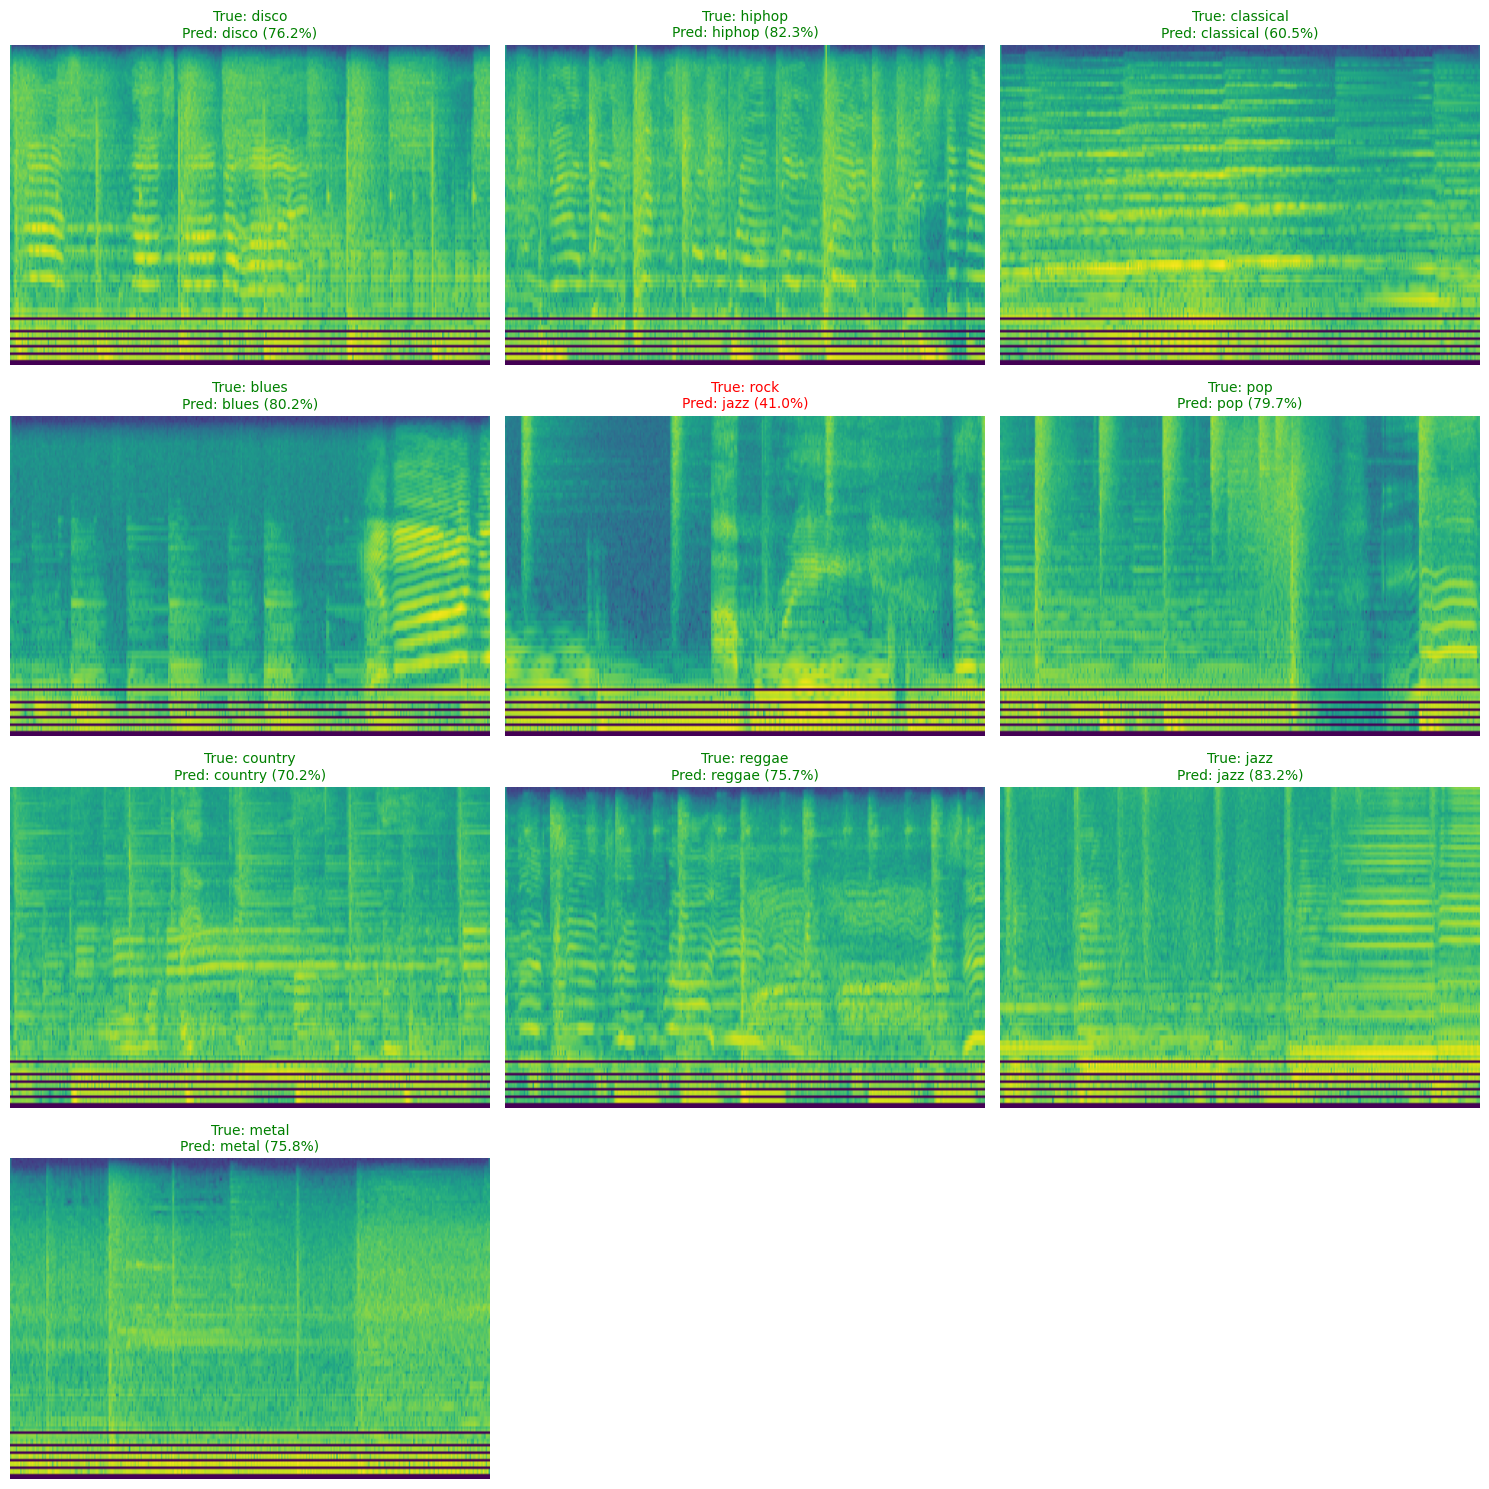

Computing confusion matrix...
Confusion matrix saved to ..\runs\20251202_104159\confusion_matrix_test.png
Confusion matrix saved to ..\runs\20251202_104159\confusion_matrix_test.png


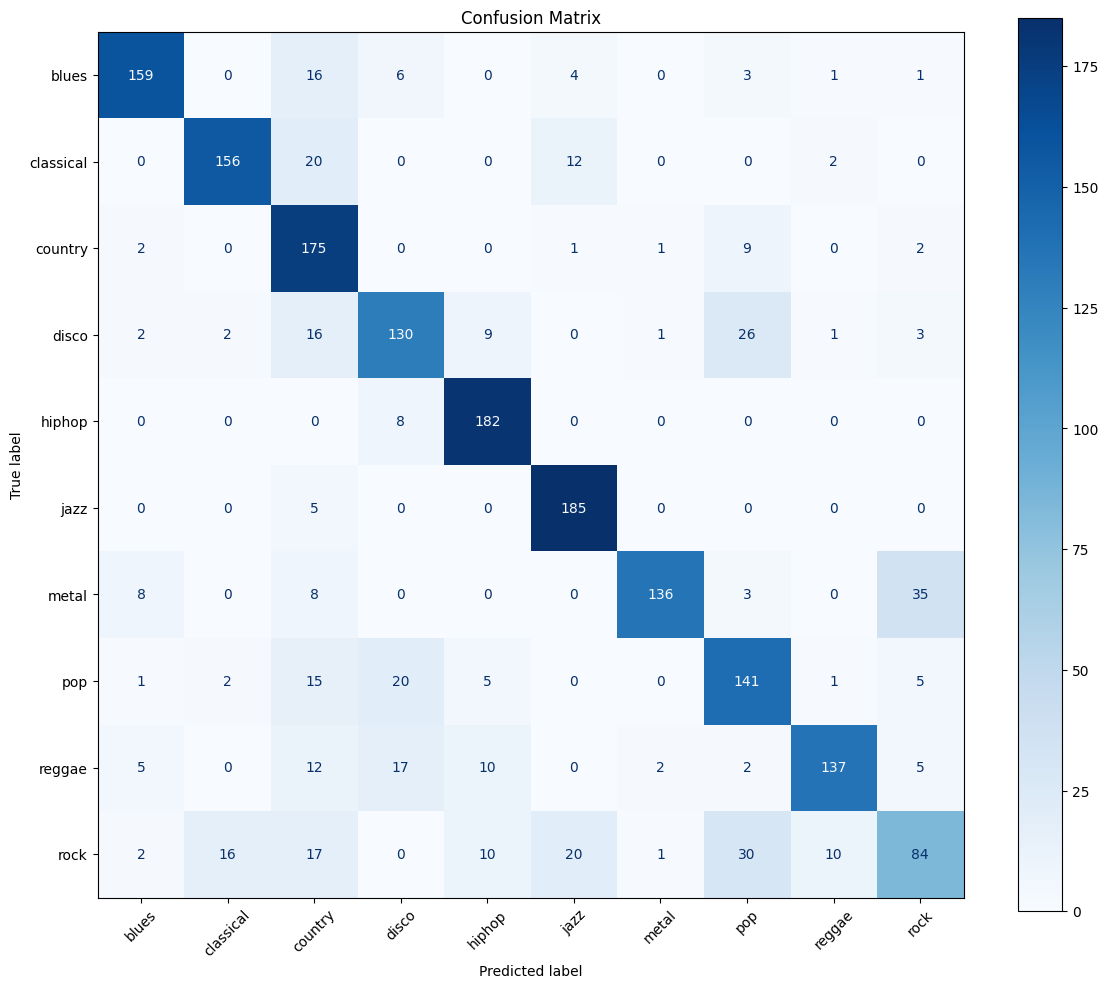

Calculating metrics on Test Set...
Test Accuracy: 78.16%
Test Precision: 0.7932
Test Recall: 0.7816
Test F1-Score: 0.7786
Results appended to ..\runs\20251202_104159\changes.md

Evaluating on 100 songs (Test) (aggregating 19 chunks each)...
Test Accuracy: 78.16%
Test Precision: 0.7932
Test Recall: 0.7816
Test F1-Score: 0.7786
Results appended to ..\runs\20251202_104159\changes.md

Evaluating on 100 songs (Test) (aggregating 19 chunks each)...


Song Eval: 100%|██████████| 100/100 [00:20<00:00,  4.83it/s]

Test Song-Level Accuracy: 82.00%


In [20]:
# GTZAN genre classification
import sys
from pathlib import Path
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm

repo_root = Path.cwd().parent
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

# Import model (prefer module; fallback to notebook)
try:
    from model_cnn import ImprovedCNN
except ModuleNotFoundError:
    print("Model module not found; loading from notebook via %run ...")
    %run "./04_model_cnn.ipynb"

# Import dataset utils
try:
    from utils.datasets_gtzan import GTZANDataset, create_dataloaders, GENRES
except ModuleNotFoundError:
    print("Dataset module not found; loading from notebook via %run ...")
    %run "./01_data_loading_gtzan.ipynb"

# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
GENRE_NAMES = ['blues', 'classical', 'country', 'disco', 'hiphop', 
               'jazz', 'metal', 'pop', 'reggae', 'rock']

# Update this to your latest run directory
run_dir = Path("../runs/20251202_104159/") 
model_path = run_dir / 'gtzan_cnn.pth'

if not model_path.exists():
    print(f"Warning: Model not found at {model_path}. Please check the path.")
else:
    # Load model
    model = load_trained_model(
        ImprovedCNN, 
        str(model_path), 
        n_classes=10, 
        device=device
    )

    # 1. Single File Prediction
    print("\n--- Single File Prediction ---")
    audio_path = '../data/gtzan/country/country.00001.wav'
    if Path(audio_path).exists():
        predicted_genre, confidence, probs = predict_genre(
            model, audio_path, GENRE_NAMES, device
        )
        visualize_prediction(audio_path, probs, GENRE_NAMES, save_path=str(run_dir / 'prediction_single.png'))
    else:
        print(f"Audio file not found: {audio_path}")

    # 2. Batch Visualization & Confusion Matrix
    print("\n--- Batch Evaluation ---")
    # Create validation dataloader
    gtzan_root = repo_root / "data" / "gtzan"
    if gtzan_root.exists():
        dataset = GTZANDataset(str(gtzan_root), cache_to_memory=False)
        
        # Use chunking for evaluation as well to match training
        # We need to use the same test_split as in training to get the correct test set
        _, _, test_loader = create_dataloaders(
            dataset, 
            batch_size=32, 
            chunk_length_sec=3.0,
            test_split=0.1
        )
        
        # Visualize Batch Predictions
        print("Visualizing batch predictions on Test Set...")
        visualize_batch_predictions(
            model, test_loader, GENRE_NAMES, device, 
            num_samples=16, 
            save_path=str(run_dir / 'prediction_batch_test.png')
        )
        
        # Plot Confusion Matrix
        plot_confusion_matrix(
            model, test_loader, GENRE_NAMES, device, 
            save_path=str(run_dir / 'confusion_matrix_test.png')
        )
        
        # Calculate and save metrics to changes.md
        print("Calculating metrics on Test Set...")
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.numpy())
        
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')
        
        print(f"Test Accuracy: {accuracy*100:.2f}%")
        print(f"Test Precision: {precision:.4f}")
        print(f"Test Recall: {recall:.4f}")
        print(f"Test F1-Score: {f1:.4f}")
        
        changes_file = run_dir / "changes.md"
        if changes_file.exists():
            with open(changes_file, "a") as f:
                f.write("\n## Inference Results (Test Set)\n")
                f.write(f"- Test Accuracy: {accuracy*100:.2f}%\n")
                f.write(f"- Test Precision: {precision:.4f}\n")
                f.write(f"- Test Recall: {recall:.4f}\n")
                f.write(f"- Test F1-Score: {f1:.4f}\n")
                f.write(f"- Confusion Matrix: [confusion_matrix_test.png](./confusion_matrix_test.png)\n")
                f.write(f"- Batch Predictions: [prediction_batch_test.png](./prediction_batch_test.png)\n")
            print(f"Results appended to {changes_file}")
            
        # Evaluate by song
        evaluate_by_song(model, test_loader.dataset, device, changes_file=changes_file, split_name="Test")
            
    else:
        print(f"Dataset root not found: {gtzan_root}")

### Music Tagging Example

In [21]:
# Example for MTAT music tagging
# Uncomment and adapt to your setup

# from notebooks.model_cnn import DeepCNN

# # Load model
# TAG_NAMES = ['rock', 'pop', 'alternative', 'indie', ...]  # Your tag list
# model = load_trained_model(
#     DeepCNN,
#     '../models/mtat_cnn.pth',
#     n_classes=50,
#     device=device
# )

# # Predict tags
# audio_path = '../data/test_audio.wav'
# predicted_tags, top_tags = predict_tags(
#     model, audio_path, TAG_NAMES, device, threshold=0.3, top_k=10
# )